In [1]:
#from utils.functions import *
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import os
import multiprocessing as mp
from torchvision.transforms import CenterCrop
import random
import numpy as np
np.set_printoptions(threshold=np.inf)
from PIL import Image
import cv2
from segment_anything import sam_model_registry, SamPredictor
from utils.functions import loadimg
from utils.functions import loadmask
from copy import deepcopy
import matplotlib.pyplot as plt
from utils.visual import *
import shutil
from random import sample

In [2]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
 
 
def show_points(coords, labels, ax, marker_size=80):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red',
               linewidth=1.25)

    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [4]:
# load original model
checkpoint = 'model/sam_vit_b_01ec64.pth'
sam = sam_model_registry['vit_b'](checkpoint=checkpoint)  # ViT-Huge

# load fine-tuned decoder
model_path = r'output/'
sam_tuned = deepcopy(sam)
sam_tuned.mask_decoder.load_state_dict(torch.load(model_path + 'finetuned_decoder_epoch100_batch1000_score0.7966.pth'))

sam.to(device)
sam_tuned.to(device)

sam.eval()
sam_tuned.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
predictor_tuned = SamPredictor(sam_tuned)
predictor_original = SamPredictor(sam)

image = cv2.imread('image_BJ/512_6_6_6.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

[[200 400]
 [160 360]]
[1 1]


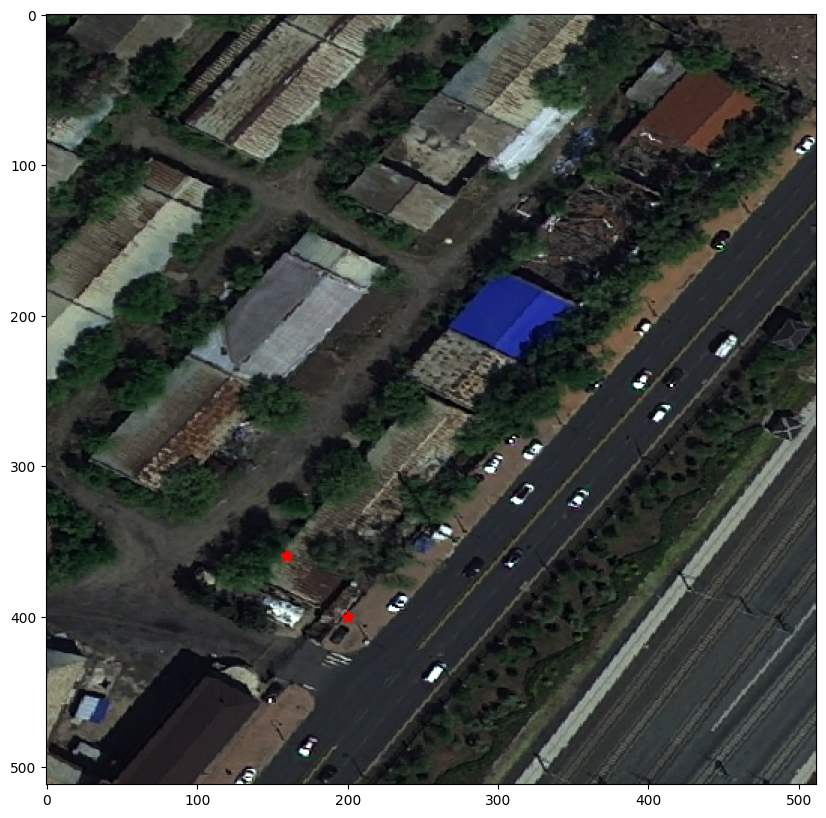

In [6]:
input_point = np.array([[200, 400], [160, 360]])
print(input_point)
input_label = np.array([1, 1])
print(input_label)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [35]:
masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

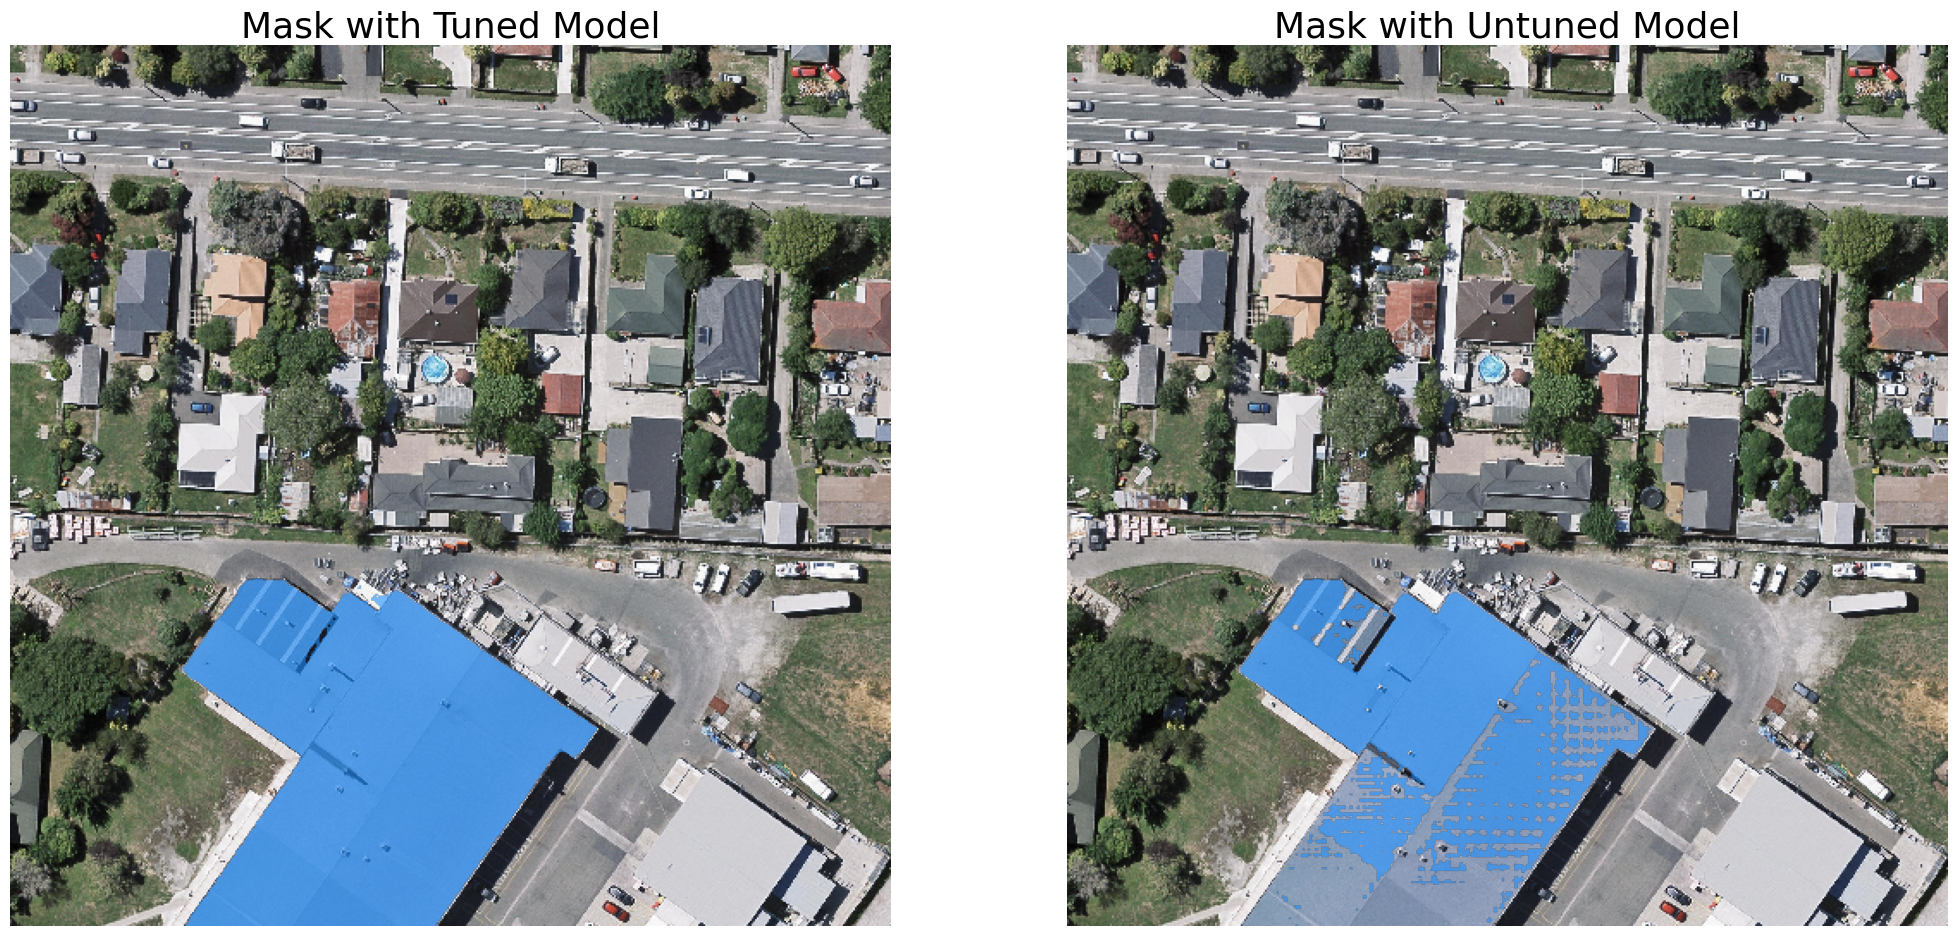

In [46]:
%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))

input_point_1 = input_point
input_label_1 = input_label

axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  